1. Value-based methods with deep neural network [50 points]
Implement Q-learning and Exptected SARSA for both Acrobot-v1 1 and ALE/Assault-ram-v52
environments from the Gym suite using the following guidelines:
• Use a Neural Network approximation for Q, that is, if x is a vector representing the state
and a is the action vector, use Q value(x) = M LP (x; θ), where θ are the parameters of the
Value function you need to learn, Q ∈ Rm where m denotes the number of discrete actions.
• Model configuration: Initialize the parameters for the value function uniformly between
−0.001 and 0.001, we recommend using either a 2 or 3-layer Neural Network for the Value
function, with a hidden dimension of 256.
• Use an ϵ- greedy policy with three choices of ϵ and step-size parameters 1/4, 1/8, 1/16. and
run 50 learning trials with different initializations for the Value function, each having 1000
episodes, for each configuration. That means 3(ϵ’s) * 3 (step-sizes) * 50 runs * 1000 episodes.
• Repeat the Previous step using a replay buffer (with transitions randomly sampled) and do
gradient updates using a mini-batch of transitions. The capacity of the replay buffer is 1M.
• Plot training curves with the mean across seeds as lines and the standard deviation as a shaded
region. (Performance on the Y-axis, and the episode on the X-axis). Generate 18 graphs
covering all configurations per environment. Present separate plots for each environment,
with distinct graphs for settings with and without a replay buffer. Use green for Q-Learning
and red for Expected SARSA, differentiating hyperparameters with different line styles (e.g.,
solid, dashed).
• Implement all the methods using any automatic differentiation package, such as Py-
torch

In [1]:
# Implement Q-learning and Exptected SARSA for both Acrobot-v1 1 and ALE/Assault-ram-v52 environments from the Gym suite using the following guidelines:

# • Use a Neural Network approximation for Q, that is, if x is a vector representing the state and a is the action vector, use Q value(x) = M LP (x; θ), where θ are the parameters of the Value function you need to learn, Q ∈ Rm where m denotes the number of discrete actions.

# • Model configuration: Initialize the parameters for the value function uniformly between −0.001 and 0.001, we recommend using either a 2 or 3-layer Neural Network for the Value function, with a hidden dimension of 256.

# • Use an ϵ- greedy policy with three choices of ϵ and step-size parameters 1/4, 1/8, 1/16. and run 50 learning trials with different initializations for the Value function, each having 1000 episodes, for each configuration. That means 3(ϵ’s) * 3 (step-sizes) * 50 runs * 1000 episodes.

# • Repeat the Previous step using a replay buffer (with transitions randomly sampled) and do gradient updates using a mini-batch of transitions. The capacity of the replay buffer is 1M.

# • Plot training curves with the mean across seeds as lines and the standard deviation as a shaded region. (Performance on the Y-axis, and the episode on the X-axis). Generate 18 graphs covering all configurations per environment. Present separate plots for each environment, with distinct graphs for settings with and without a replay buffer. Use green for Q-Learning and red for Expected SARSA, differentiating hyperparameters with different line styles (e.g., solid, dashed).

# • Implement all the methods using any automatic differentiation package, such as Py-torch

In [2]:
env_name = 'Acrobot-v1'
# env_name = 'Assault-ram-v0'

import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
from collections import deque
import matplotlib.pyplot as plt
import os
import time
import pickle

# Hyperparameters
EPISODES = 1000
MAX_STEPS = 1000
GAMMA = 0.99
HIDDEN_DIM = 256
SEEDS = 10

# Environment
env = gym.make(env_name)
env._max_episode_steps = MAX_STEPS

state_dim = env.observation_space.shape[0]
action_dim = env.action_space.n

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
# device = "mps"

# Neural Network
class QNetwork(nn.Module):
    def __init__(self):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_dim, HIDDEN_DIM)
        self.fc2 = nn.Linear(HIDDEN_DIM, HIDDEN_DIM)
        self.fc3 = nn.Linear(HIDDEN_DIM, action_dim)

        # Initialize parameters
        for m in self.modules():
            if isinstance(m, nn.Linear):
                print("initializing layer", m)
                nn.init.uniform_(m.weight, -0.01, 0.01)
                nn.init.uniform_(m.bias, -0.01, 0.01)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x

# Q-Learning
def q_learning(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    q_network.to(device)
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(device)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # for i in range(batch_size):
                #     target_q_values[i][action_batch[i]] = reward_batch[i] + GAMMA * next_q_values[i].max() * (1 - done_batch[i])
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * next_q_values.max(dim=1).values * (1 - done_batch)
                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())

    return rewards

# Expected SARSA
def expected_sarsa(lr, batch_size, replay_buffer_size, epsilon):
    q_network = QNetwork()
    q_network_target = QNetwork()
    q_network_target.load_state_dict(q_network.state_dict())
    optimizer = optim.Adam(q_network.parameters(), lr=lr, eps=0.0003125)
    replay_buffer = deque(maxlen=replay_buffer_size)
    rewards = []
    for episode in range(EPISODES):
        state, info = env.reset()
        done = False
        total_reward = 0
        while not done:
            with torch.no_grad():
                if random.random() < epsilon:
                    action = env.action_space.sample()
                else:
                    state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0)
                    action = q_network(state_tensor).argmax().item()
                next_state, reward, terminated, truncated, _ = env.step(action)
                done = terminated or truncated
                total_reward += reward
                replay_buffer.append((state, action, reward, next_state, done))
            if len(replay_buffer) >= batch_size:
                batch = random.sample(replay_buffer, batch_size)
                state_batch, action_batch, reward_batch, next_state_batch, done_batch = zip(*batch)
                state_batch = torch.tensor(np.array(state_batch), dtype=torch.float32).to(device)
                action_batch = torch.tensor(np.array(action_batch), dtype=torch.long).to(device)
                reward_batch = torch.tensor(np.array(reward_batch), dtype=torch.float32).to(device)
                next_state_batch = torch.tensor(np.array(next_state_batch), dtype=torch.float32).to(device)
                done_batch = torch.tensor(np.array(done_batch), dtype=torch.float32).to(device)
                q_values = q_network(state_batch)
                next_q_values = q_network_target(next_state_batch)
                # next_q_values = q_network(next_state_batch)
                target_q_values = q_values.clone()
                # expected sarsa
                probs = torch.ones(batch_size, action_dim) * epsilon / action_dim
                probs[range(batch_size), next_q_values.argmax(dim=1)] += 1 - epsilon
                target_q_values[range(batch_size), action_batch] = reward_batch + GAMMA * (probs * next_q_values).sum(dim=1) * (1 - done_batch)

                loss = nn.MSELoss()(q_values, target_q_values)
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()
            state = next_state
        rewards.append(total_reward)
        if episode % 10 == 0:
            q_network_target.load_state_dict(q_network.state_dict())
            print(episode, total_reward, loss.item())
    return rewards


def run_experiment(lr, batch_size, replay_buffer_size, epsilon, seeds):
    random_seeds = [0, 1, 2, 3, 4, 5, 6, 8, 11, 12]
    print(seeds)
    q_learning_rewards = np.zeros((seeds, EPISODES))
    expected_sarsa_rewards = np.zeros((seeds, EPISODES))
    if os.path.exists(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_q_learning_rewards = pickle.load(open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)] = old_q_learning_rewards[:min(old_q_learning_rewards.shape[0], seeds)]
    if os.path.exists(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl'):
        old_expected_sarsa_rewards = pickle.load(open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'rb'))
        expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)] = old_expected_sarsa_rewards[:min(old_expected_sarsa_rewards.shape[0], seeds)]
    # for i, seed in enumerate(random_seeds):
    for i in range(seeds):
        print(f'Run {i+1}/{seeds}')
        if q_learning_rewards[i].sum() == 0:
            print('Q-Learning')
            q_learning_rewards[i] = q_learning(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(q_learning_rewards, open(f'q_learning_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        if expected_sarsa_rewards[i].sum() == 0:
            print('Expected SARSA')
            expected_sarsa_rewards[i] = expected_sarsa(lr, batch_size, replay_buffer_size, epsilon)
            pickle.dump(expected_sarsa_rewards, open(f'expected_sarsa_rewards_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.pkl', 'wb'))
        q_learning_rewards_mean = q_learning_rewards[:i+1].mean(axis=0)
        q_learning_rewards_std = q_learning_rewards[:i+1].std(axis=0)
        expected_sarsa_rewards_mean = expected_sarsa_rewards[:i+1].mean(axis=0)
        expected_sarsa_rewards_std = expected_sarsa_rewards[:i+1].std(axis=0)
        plt.plot(q_learning_rewards_mean, label='Q-Learning', color='green')
        plt.fill_between(range(EPISODES), q_learning_rewards_mean - q_learning_rewards_std, q_learning_rewards_mean + q_learning_rewards_std, color='green', alpha=0.2)
        plt.plot(expected_sarsa_rewards_mean, label='Expected SARSA', color='red')
        plt.fill_between(range(EPISODES), expected_sarsa_rewards_mean - expected_sarsa_rewards_std, expected_sarsa_rewards_mean + expected_sarsa_rewards_std, color='red', alpha=0.2)
        plt.title(f'lr={lr}, batch_size={batch_size}, replay_buffer_size={replay_buffer_size}, epsilon={epsilon}')
        plt.xlabel('Episode')
        plt.ylabel('Reward')
        plt.legend()
        plt.savefig(f'plot_{i}_{lr}_{batch_size}_{replay_buffer_size}_{epsilon}.png')
        plt.show()

In [3]:
# SEEDS = 1
# EPISODES = 1000
# run_experiment(0.001, 128, 1000000, 0.25)

0.0001 32 1000000 0.25
1
Run 1/1


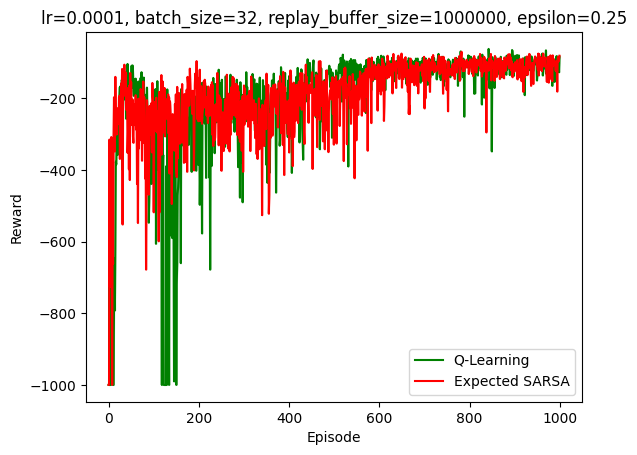

0.0001 32 1000000 0.1
1
Run 1/1
Expected SARSA
initializing layer Linear(in_features=6, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=3, bias=True)
initializing layer Linear(in_features=6, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=3, bias=True)


/Users/jonathanlamontange-kratz/Library/Python/3.9/lib/python/site-packages/gym/utils/passive_env_checker.py:233: DeprecationWarning: `np.bool8` is a deprecated alias for `np.bool_`.  (Deprecated NumPy 1.24)
  if not isinstance(terminated, (bool, np.bool8)):


0 -1000.0 0.0013739500427618623
10 -1000.0 6.447007763199508e-05
20 -351.0 9.163504000753164e-05
30 -94.0 0.00030398325179703534
40 -62.0 0.0009639545460231602
50 -454.0 0.0016207917360588908
60 -284.0 0.00334942527115345
70 -185.0 0.00549974525347352
80 -119.0 0.00545249180868268
90 -284.0 0.005276238080114126
100 -197.0 0.03150336816906929
110 -123.0 0.015829820185899734
120 -549.0 0.7036116719245911
130 -850.0 0.029510000720620155
140 -1000.0 0.9040253162384033
150 -320.0 0.1792290061712265
160 -148.0 0.006474565714597702
170 -205.0 0.01052980124950409
180 -128.0 0.13877376914024353
190 -230.0 0.015578086487948895
200 -170.0 0.019808979704976082
210 -233.0 0.7062512040138245
220 -202.0 0.043024349957704544
230 -110.0 2.034736394882202
240 -97.0 0.01657705567777157
250 -191.0 0.03594810888171196
260 -126.0 0.01967492885887623
270 -178.0 1.7422903776168823
280 -138.0 0.29152601957321167
290 -190.0 0.5315474271774292
300 -225.0 0.024910805746912956
310 -104.0 0.06536294519901276
320 -1

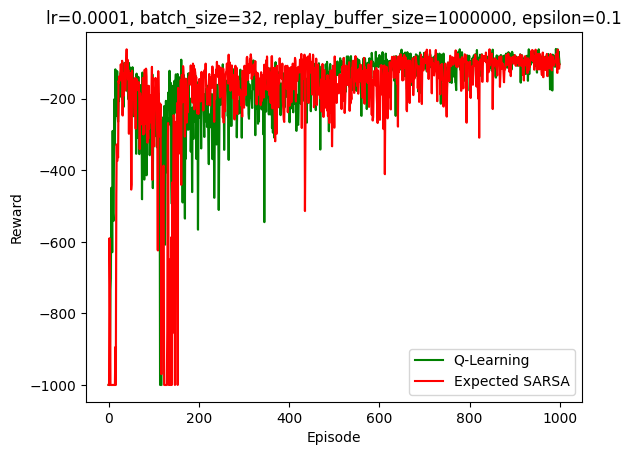

0.0001 32 1000000 0.01
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=6, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=3, bias=True)
initializing layer Linear(in_features=6, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=3, bias=True)
0 -856.0 0.004756603855639696
10 -380.0 0.00040523381903767586
20 -302.0 0.0010181012330576777
30 -242.0 0.0009885858744382858
40 -145.0 0.13746535778045654
50 -203.0 0.008722401224076748
60 -155.0 0.006386525928974152
70 -142.0 0.0009367088787257671
80 -282.0 0.0036637866869568825
90 -447.0 0.016030190512537956
100 -595.0 0.0025618986692279577
110 -322.0 0.03168562427163124
120 -369.0 0.0069633894599974155
130 -493.0 0.005239304155111313
140 -735.0 0.017560450360178947
150 -341.0 0.030796634033322334
160 -470.0 0.011359400115

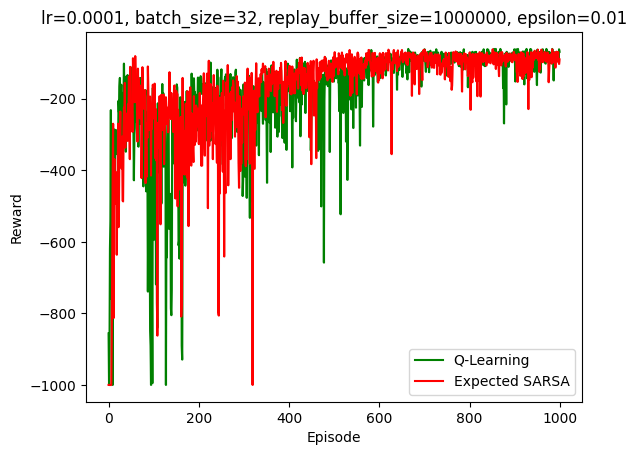

0.001 32 1000000 0.25
1
Run 1/1
Q-Learning
initializing layer Linear(in_features=6, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=3, bias=True)
initializing layer Linear(in_features=6, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=256, bias=True)
initializing layer Linear(in_features=256, out_features=3, bias=True)
0 -1000.0 0.00019304289889987558
10 -392.0 0.00042075349483639
20 -791.0 0.00024194880097638816
30 -305.0 0.06394185870885849
40 -180.0 0.0018506370251998305
50 -266.0 0.00394443841651082
60 -350.0 0.027118956670165062
70 -713.0 0.0028456735890358686
80 -264.0 0.0024728223215788603
90 -263.0 0.004137647338211536
100 -127.0 0.017922325059771538
110 -459.0 0.007770441938191652
120 -222.0 0.4292883574962616
130 -903.0 0.011563402600586414
140 -291.0 0.01754402555525303
150 -201.0 0.016885416582226753
160 -268.0 0.03643706813454628

In [ ]:
epsilons = [0.25, 0.1, 0.01]
# lrs = [1/4, 1/8, 1/16]
lrs = [0.0001, 0.001, 0.01]
replay_buffers = [(32, 1000000), (1, 1)]
for i in range(1, 10):
    for replay_buffer in replay_buffers:
        for lr in lrs:
            for epsilon in epsilons:
                print(lr, replay_buffer[0], replay_buffer[1], epsilon)
                run_experiment(lr, replay_buffer[0], replay_buffer[1], epsilon, i)


In [ ]:
def reinforce(stepsize, episodes, lr):
    q_network = QNetwork()
    for i in range(episodes):
        ep = []
        state = env.reset()
        done = False
        while not done:
            action = np.random.choice(env.action_space, p=[i.item() for i in q_network(state)])
            next_state, reward, done, _ = env.step(action)
            ep.append((state, action, reward))
            state = next_state
        grad = 0
        for t in range(len(ep)):
            G = sum([r for (_, _, r) in ep[t:]]) # sum of rewards from time t
        return q_network